In [98]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, utils
from torchvision.transforms import Resize, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

from PIL import Image
from tqdm.auto import tqdm

from sklearn.metrics import f1_score

In [99]:
TRAIN_PATH = '/opt/ml/input/data/train/'
TRAIN_IMAGE_PATH = '/opt/ml/input/data/train/processed_train_images/'

In [100]:
train_df = pd.read_csv(os.path.join(TRAIN_PATH, 'preprocessed_train.csv'))
train_df

,Unnamed: 0,id,gender,mask,age,age_3,age_11,label,path
0,0,003792,0,0,30,1,3,1,/opt/ml/input/data/train/processed_train_image...
1,1,000036,1,0,58,1,5,4,/opt/ml/input/data/train/processed_train_image...
2,2,003880,1,0,55,1,5,4,/opt/ml/input/data/train/processed_train_image...
3,3,003136,1,0,19,0,1,3,/opt/ml/input/data/train/processed_train_image...
4,4,006167,1,0,18,0,1,3,/opt/ml/input/data/train/processed_train_image...
...,...,...,...,...,...,...,...,...,...
18888,18888,003361,1,0,20,0,2,3,/opt/ml/input/data/train/processed_train_image...
18889,18889,006170,1,0,20,0,2,3,/opt/ml/input/data/train/processed_train_image...
18890,18890,003172,1,0,19,0,1,3,/opt/ml/input/data/train/processed_train_image...
18891,18891,001531,1,2,26,0,2,15,/opt/ml/input/data/train/processed_train_image...


In [101]:
class maskDataset(Dataset):
    def __init__(self, train_df, transform, train=True):
        self.train = train
        self.transform = transform

        if self.train == True:
            self.paths = train_df['path']
            self.labels = train_df['label']
        else:
            self.paths = train_df
        

    def __getitem__(self, index):
        if self.train:
            image = Image.open(self.paths.iloc[index])
            label = self.labels.iloc[index]
        else:
            image = Image.open(self.paths[index])

        if self.transform:
            image = self.transform(image)

        if self.train:
            return image, torch.tensor(label)
        else:
            return image

    def __len__(self):
        return len(self.paths)

In [102]:
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    #Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2))
])

In [103]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(train_df, test_size=0.2, shuffle=True, stratify=train_df['label'], random_state=34)

In [104]:
train.shape, valid.shape

((15114, 9), (3779, 9))

In [105]:
BATCH_SIZE = 16

In [106]:
train_dataset = maskDataset(train, transform)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=1)

In [107]:
a = train_dataset
a[0][0].shape

torch.Size([3, 512, 384])

In [108]:
valid_dataset = maskDataset(valid, transform)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=1)

In [109]:
from facenet_pytorch import MTCNN, InceptionResnetV1

### - 한번만 설치

pip install ipywidgets                 
jupyter nbextension enable --py widgetsnbextension

In [110]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ('My Device :', device)

detector = MTCNN(device=device, post_process=False)
resnet = InceptionResnetV1(pretrained='vggface2')

My Device : cuda:0


### 사진 한 장 확인

In [111]:
data = next(iter(train_dataloader))
one = data[0][0]
one_label = data[1][0]
print(one.shape)
print(one_label)

torch.Size([3, 512, 384])
tensor(4)


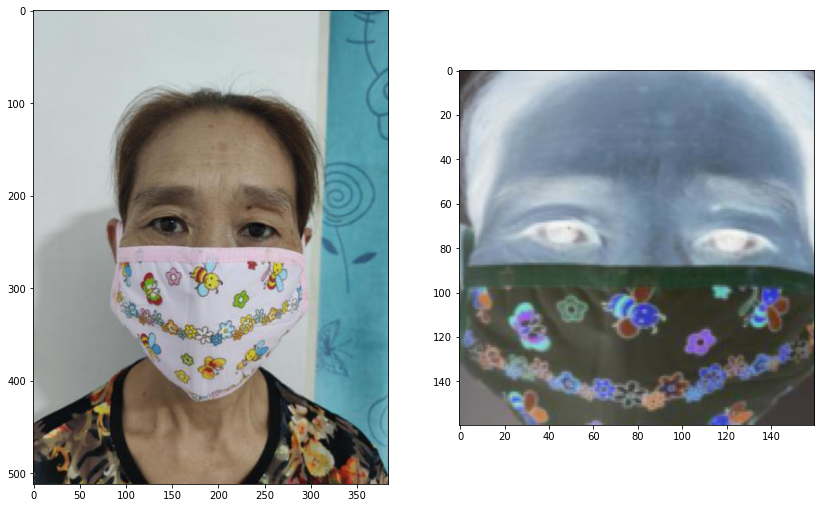

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(14, 14))
tf = transforms.ToPILImage()

one = tf(one)
axes[0].imshow(one)

one = detector(one)
axes[1].imshow(tf(one))

plt.show()

### 배치 단위로 확인

In [113]:
data2 = next(iter(train_dataloader))
print ('data2 size =', data2[0])
x = data2[0][:16]
x_label = data2[1][:16]
print(x.shape)
print(x_label.shape)

data2 size = tensor([[[[0.7529, 0.7529, 0.7529,  ..., 0.6706, 0.6706, 0.6706],
          [0.7529, 0.7529, 0.7529,  ..., 0.6706, 0.6706, 0.6706],
          [0.7529, 0.7529, 0.7529,  ..., 0.6706, 0.6706, 0.6667],
          ...,
          [0.4039, 0.4157, 0.4235,  ..., 0.2235, 0.2157, 0.2196],
          [0.4039, 0.4157, 0.4275,  ..., 0.2235, 0.2235, 0.2275],
          [0.4078, 0.4157, 0.4314,  ..., 0.2235, 0.2275, 0.2353]],

         [[0.7529, 0.7529, 0.7529,  ..., 0.6588, 0.6588, 0.6588],
          [0.7529, 0.7529, 0.7529,  ..., 0.6588, 0.6588, 0.6588],
          [0.7529, 0.7529, 0.7529,  ..., 0.6588, 0.6588, 0.6549],
          ...,
          [0.4157, 0.4275, 0.4353,  ..., 0.2314, 0.2353, 0.2392],
          [0.4157, 0.4275, 0.4392,  ..., 0.2314, 0.2431, 0.2471],
          [0.4196, 0.4275, 0.4431,  ..., 0.2314, 0.2471, 0.2549]],

         [[0.7216, 0.7216, 0.7216,  ..., 0.6314, 0.6314, 0.6314],
          [0.7216, 0.7216, 0.7216,  ..., 0.6314, 0.6314, 0.6314],
          [0.7216, 0.7216, 0.

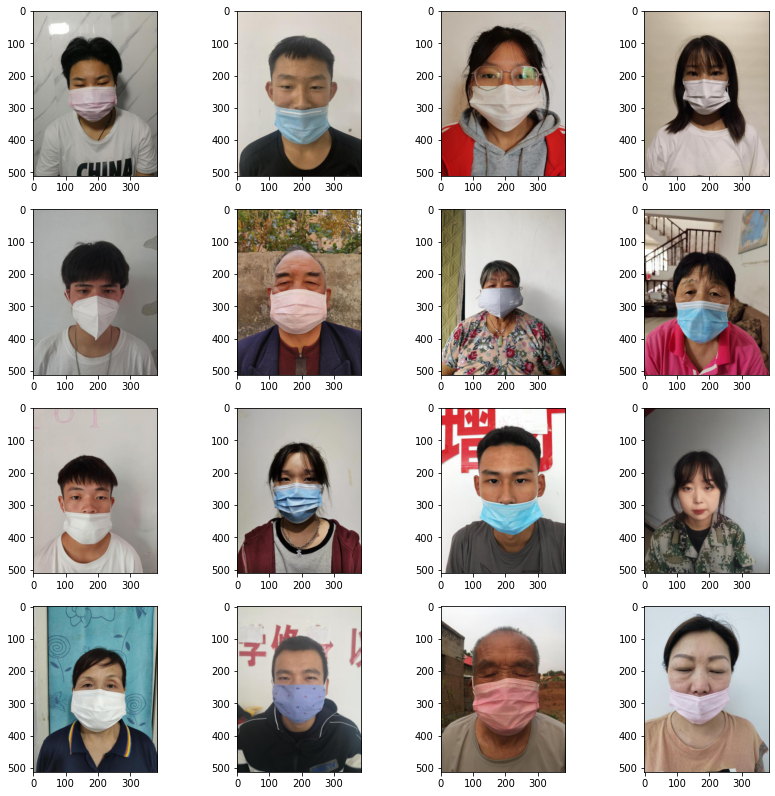

In [114]:
fig, axes = plt.subplots(4, 4, figsize=(14, 14))
tf = transforms.ToPILImage()

for i in range(16):
    r,c = i//4, i%4
    axes[r][c].imshow(tf(x[i]))

plt.show()


In [115]:
fig, axes = plt.subplots(4, 4, figsize=(14, 14))
tf = transforms.ToPILImage()

for i in range(16):
    r,c = i//4, i%4
    image = tf(x[i])
    image = detector(image)
    print(image)
    axes[r][c].imshow(tf(image))

plt.show()

tensor([[[  6.,   6.,   5.,  ...,  10.,   8.,   6.],
         [  6.,   6.,   5.,  ...,  11.,   9.,   7.],
         [  5.,   7.,   6.,  ...,  12.,   9.,   7.],
         ...,
         [172., 176., 177.,  ...,  46.,  43.,  40.],
         [172., 175., 176.,  ...,  42.,  41.,  39.],
         [170., 173., 174.,  ...,  42.,  39.,  37.]],

        [[  8.,   8.,   7.,  ...,  12.,  10.,   8.],
         [  8.,   8.,   7.,  ...,  13.,  11.,   9.],
         [  7.,   9.,   8.,  ...,  14.,  11.,   9.],
         ...,
         [173., 175., 176.,  ...,  33.,  31.,  28.],
         [173., 174., 175.,  ...,  30.,  31.,  29.],
         [171., 173., 173.,  ...,  30.,  29.,  28.]],

        [[  7.,   5.,   4.,  ...,   9.,   7.,   5.],
         [  7.,   5.,   4.,  ...,  10.,   8.,   6.],
         [  6.,   6.,   5.,  ...,  11.,   8.,   6.],
         ...,
         [167., 170., 171.,  ...,  19.,  18.,  16.],
         [167., 169., 170.,  ...,  17.,  18.,  19.],
         [165., 167., 168.,  ...,  17.,  17.,  19.]]]

In [ ]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()
faces = []  #[tensor, tensor, ....]
for image, label in zip(x, x_label):
    face = detector(tf(image))
    faces.append(face)

faces = torch.stack(faces, dim=0)
print(faces.shape)
resnet.classify = True
image_embedding = resnet(faces)
#print(image_embedding.shape)
pred = image_embedding.argmax(dim=1)
pred

torch.Size([16, 3, 160, 160])


tensor([2804, 3293, 3293, 3293, 3293, 2804, 3293, 3293, 3293, 3883, 1378, 3293,
        2280, 2804, 3883, 1378])

In [ ]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()
resnet.classify = True
# print(one.shape)
# print(type(one))
# print(one.unsqueeze(0).shape)
img_prob = resnet(one.unsqueeze(0))
print(img_prob)  # shape: (1, 8631)
torch.max(img_prob, 1)

tensor([[-13.9579,   4.3976,  -5.7387,  ...,  -9.7598,   4.9549,   1.6972]],
       grad_fn=<AddmmBackward>)


torch.return_types.max(
values=tensor([35.4331], grad_fn=<MaxBackward0>),
indices=tensor([3293]))

In [ ]:
help(resnet)

Help on InceptionResnetV1 in module facenet_pytorch.models.inception_resnet_v1 object:

class InceptionResnetV1(torch.nn.modules.module.Module)
 |  InceptionResnetV1(pretrained=None, classify=False, num_classes=None, dropout_prob=0.6, device=None)
 |  
 |  Inception Resnet V1 model with optional loading of pretrained weights.
 |  
 |  Model parameters can be loaded based on pretraining on the VGGFace2 or CASIA-Webface
 |  datasets. Pretrained state_dicts are automatically downloaded on model instantiation if
 |  requested and cached in the torch cache. Subsequent instantiations use the cache rather than
 |  redownloading.
 |  
 |  Keyword Arguments:
 |      pretrained {str} -- Optional pretraining dataset. Either 'vggface2' or 'casia-webface'.
 |          (default: {None})
 |      classify {bool} -- Whether the model should output classification probabilities or feature
 |          embeddings. (default: {False})
 |      num_classes {int} -- Number of output classes. If 'pretrained' is 

In [ ]:
ResNet18 = torchvision.models.resnet34(pretrained=True)

In [ ]:
ResNet18.fc = torch.nn.Linear(in_features=512, out_features=18, bias=True)

torch.nn.init.kaiming_normal_(ResNet18.fc.weight)
torch.nn.init.zeros_(ResNet18.fc.bias)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ('My Device :', device)

My Device : cuda:0


In [ ]:
ResNet18.to(device)

LEARNING_RATE = 1e-4
NUM_EPOCH = 5

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ResNet18.parameters(), lr=LEARNING_RATE)

dataloaders = {
    "train" : train_dataloader,
    "valid" : valid_dataloader
}

In [ ]:
resnet = InceptionResnetV1(pretrained='vggface2', num_classes=18, device=device, classify=True)
resnet.classify = True
resnet.logits = nn.Linear(512, 18)
resnet.to(device)

LEARNING_RATE = 1e-4
NUM_EPOCH = 5

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=LEARNING_RATE)

dataloaders = {
    "train" : train_dataloader,
    "valid" : valid_dataloader
}

In [ ]:
best_acc = 0
best_loss = 0

transforom_one = transforms.CenterCrop((160, 160))

for epoch in tqdm(range(NUM_EPOCH)):
    for phase in ['train', 'valid']:
        running_loss = 0
        running_acc = 0

        if phase == 'train':
            resnet.train()
        elif phase == 'valid':
            resnet.eval()

        for idx, (images, labels) in enumerate(dataloaders[phase]):
            images = images.to(device)
            labels = labels.to(device)

            faces = []
            for img in images:
                temp = tf(img)
                face = detector(tf(img))
                if face == None:
                    face = transforom_one(img)
                face = face.to(device)
                faces.append(face)
            

            faces = torch.stack(faces, dim=0)
            faces = faces.to(device)

            # resnet = InceptionResnetV1(pretrained='vggface2').eval()
            # faces = []  #[tensor, tensor, ....]
            # for image, label in zip(x, x_label):
            #     face = detector(tf(image))
            #     faces.append(face)

            # faces = torch.stack(faces, dim=0)
            # print(faces.shape)
            # resnet.classify = True
            # image_embedding = resnet(faces)
            # #print(image_embedding.shape)
            # pred = image_embedding.argmax(dim=1)
            # pred

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                logits = resnet(faces)
                _, pred = torch.max(logits, 1)
                loss = loss_fn(logits, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * images.size(0)
            running_acc += torch.sum(pred == labels.data)
            

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_acc / len(dataloaders[phase].dataset)


        print (f'[{phase}] 현재 EPOCH : {epoch}, loss : {epoch_loss}, acc : {epoch_acc}')

tensor([ 3,  7, 14, 10,  9,  2,  9,  2,  8, 17,  8,  1, 16, 10,  1, 14],
       device='cuda:0')
[train] 현재 EPOCH : 0, loss : 0.0, acc : 0.0
tensor([11, 10, 10, 10, 10, 11, 10, 10, 10, 15, 10, 10, 10, 10,  1,  0],
       device='cuda:0')
[valid] 현재 EPOCH : 0, loss : 0.0, acc : 0.0
tensor([11, 13,  0,  0,  0, 10,  5, 12,  5,  9,  8,  2,  1,  1, 10,  2],
       device='cuda:0')
[train] 현재 EPOCH : 1, loss : 0.0, acc : 0.0
tensor([11,  9,  0, 15, 11,  6, 10, 15,  1,  1,  8,  0, 10,  1, 10, 10],
       device='cuda:0')
[valid] 현재 EPOCH : 1, loss : 0.0, acc : 0.0
tensor([ 9,  2, 12, 15, 10,  1, 10,  3, 13,  4, 14, 13,  8, 17, 15, 10],
       device='cuda:0')
[train] 현재 EPOCH : 2, loss : 0.0, acc : 0.0
tensor([17, 17,  9, 11, 11, 11, 10, 10,  0, 11, 15, 10,  8, 14, 10,  1],
       device='cuda:0')
[valid] 현재 EPOCH : 2, loss : 0.0, acc : 0.0
tensor([ 4, 13,  5, 11,  7, 10, 15, 16,  4, 11, 10, 11,  6, 17,  0, 10],
       device='cuda:0')
[train] 현재 EPOCH : 3, loss : 0.0, acc : 0.0
tensor([ 0, 1

In [ ]:
TEST_DIR = '/opt/ml/input/data/eval/'

In [ ]:
# meta 데이터와 이미지 경로를 불러옵니다
submission = pd.read_csv(os.path.join(TEST_DIR, 'info.csv'))
image_dir = os.path.join(TEST_DIR, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
dataset = maskDataset(image_paths, transform, train=False)
loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
resnet.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in tqdm(loader):
    images = images.to(device)
    faces = []
    for img in images:
        temp = tf(img)
        face = detector(tf(img))
        if face == None:
            face = transforom_one(img)
        face = face.to(device)
        faces.append(face)

    faces = torch.stack(faces, dim=0)
    faces = faces.to(device)
    with torch.no_grad():
        logits = resnet(images)
        _, pred = torch.max(logits, 1)
        # pred = pred.argmax(dim=-1)
        print ('pred =', pred)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(TEST_DIR, 'submission.csv'), index=False)
print('test inference is done!')

pred = tensor([1168], device='cuda:0')
pred = tensor([1168], device='cuda:0')
pred = tensor([1168], device='cuda:0')
pred = tensor([1168], device='cuda:0')
pred = tensor([1168], device='cuda:0')
pred = tensor([1168], device='cuda:0')
pred = tensor([1168], device='cuda:0')
pred = tensor([1168], device='cuda:0')
pred = tensor([1168], device='cuda:0')
pred = tensor([1168], device='cuda:0')
pred = tensor([1168], device='cuda:0')
pred = tensor([1168], device='cuda:0')
pred = tensor([1168], device='cuda:0')
pred = tensor([1168], device='cuda:0')
pred = tensor([1168], device='cuda:0')
pred = tensor([1168], device='cuda:0')
pred = tensor([1168], device='cuda:0')
pred = tensor([1168], device='cuda:0')
pred = tensor([1168], device='cuda:0')
pred = tensor([1168], device='cuda:0')
pred = tensor([1168], device='cuda:0')
pred = tensor([1168], device='cuda:0')
pred = tensor([1168], device='cuda:0')
pred = tensor([1168], device='cuda:0')
pred = tensor([1168], device='cuda:0')
pred = tensor([1168], dev

KeyboardInterrupt: 

In [ ]:
sorted(submission['ans'].unique())

[3]